In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import GridSearchCV
import xgboost as xgb



---


#ПОСМОТРИМ НА ДАННЫЕ

In [ ]:
data = pd.read_csv("train.csv", index_col=False)
data.head(5)

,id,plate,date,price
0,1,X059CP797,2024-12-26 00:00:00,65000
1,2,Y800MH790,2024-07-12 21:31:37,100000
2,3,A212TX77,2024-04-18 00:00:00,290000
3,4,P001AY199,2025-01-03 00:27:15,680000
4,5,P001AY199,2025-01-10 09:32:41,750000


In [ ]:
data.shape

(51635, 4)

In [ ]:
print(len(data["plate"]) - len(set(data["plate"])))

8030


#В ДАННЫХ ИМЕЮТСЯ ДУБЛИКАТЫ 8030шт. А ТОЧНЕЕ , ЭТО ПЕРЕЗАКУПКИ НОМЕРОВ. Т.Е. КОГДА ОДИН НОМЕР БЫЛ ПЕРЕПРОДАН, А В ДАТАФРЕЙМЕ ДАННЫЕ О ВСЕХ ПОКУПКАХ

<ipython-input-319-db8040c463b7>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


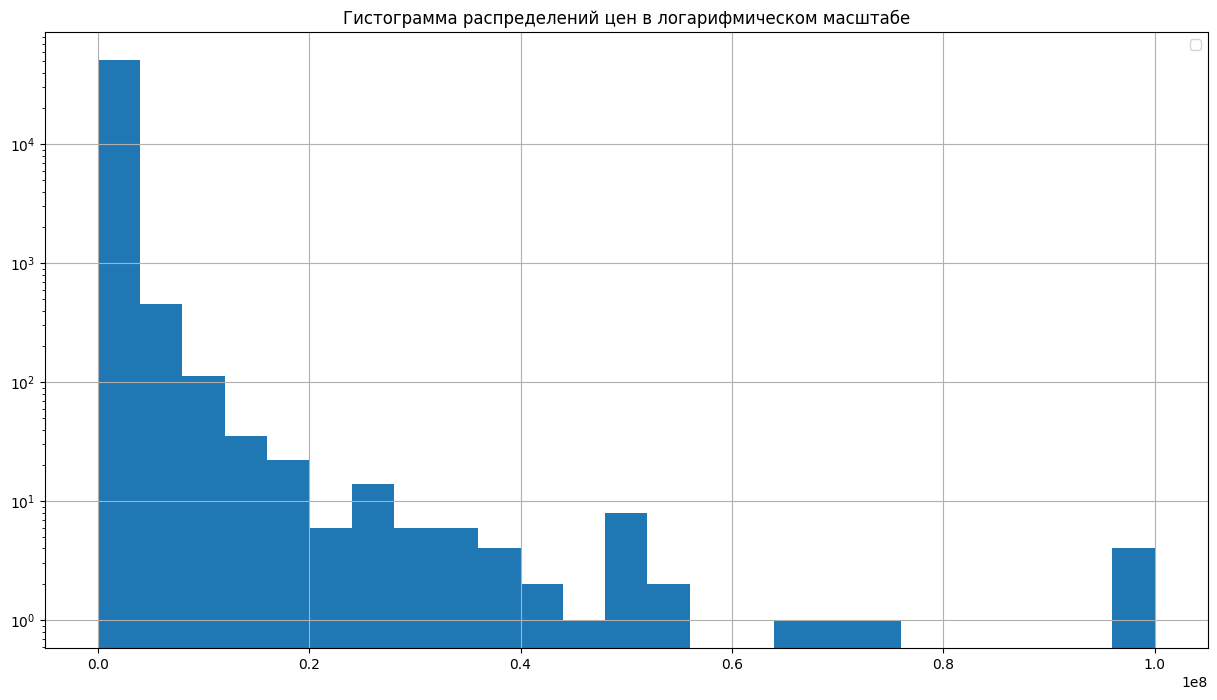

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(data["price"], bins=25, log=True)
plt.title("Гистограмма распределений цен в логарифмическом масштабе")
plt.legend()
plt.grid(True)

#ПОСМОТРИМ НА РАСПРЕДЕЛЕНИЕ ЦЕН В ЗАВИСИМОСТИ ОТ ГОРОДА

Text(0, 0.5, 'Цена')

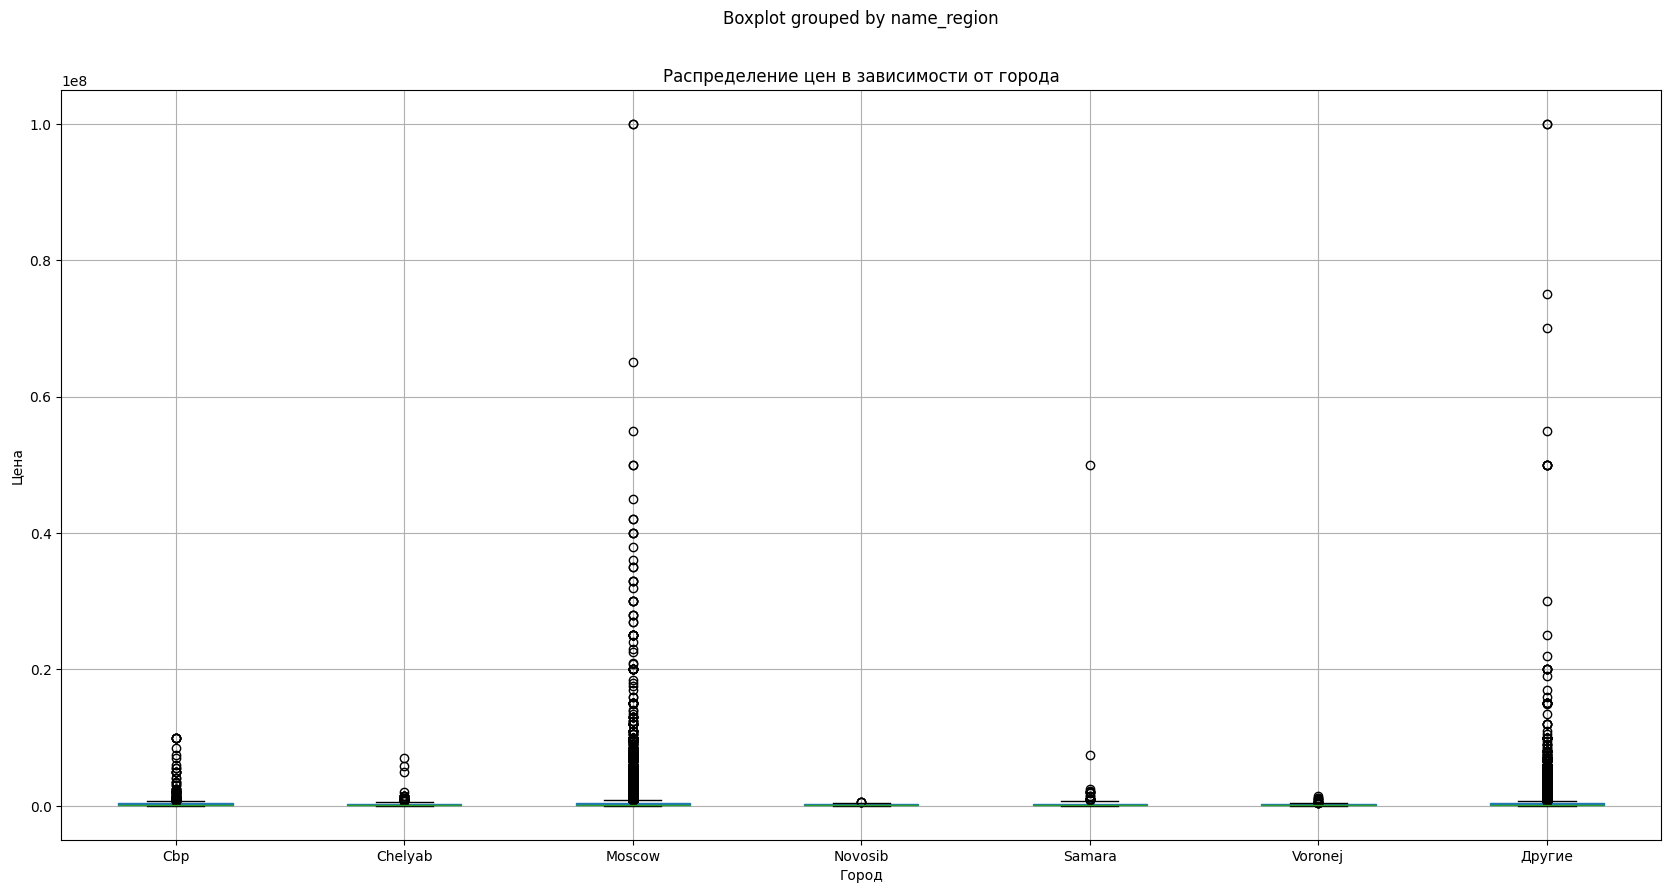

In [ ]:
def region(plate):
    return plate[-3:] if plate[-3:].isdigit() else ("0" + plate[-2:])

data["region"] = data["plate"].apply(region)

def main_region(plate):
    if plate in ["077", "097", "099", "177", "197", "199", "777", "797", "799", "977"]:
        return "Moscow"
    elif plate in ["078", "098", "178", "198"]:
        return "Cbp"
    elif plate in ["053"]:
        return "Novosib"
    elif plate in ["074", "174", "774"]:
        return "Chelyab"
    elif plate in ["063", "163", "763"]:
        return "Samara"
    elif plate in ["036", "136"]:
        return "Voronej"
    else:
        return "Другие"

data["name_region"] = data["region"].apply(main_region)

ax = data.boxplot(column="price", by="name_region", figsize=(20, 10), patch_artist=True)
ax.set_title("Распределение цен в зависимости от города")
ax.set_xlabel("Город")
ax.set_ylabel("Цена")

Text(0, 0.5, 'Цена')

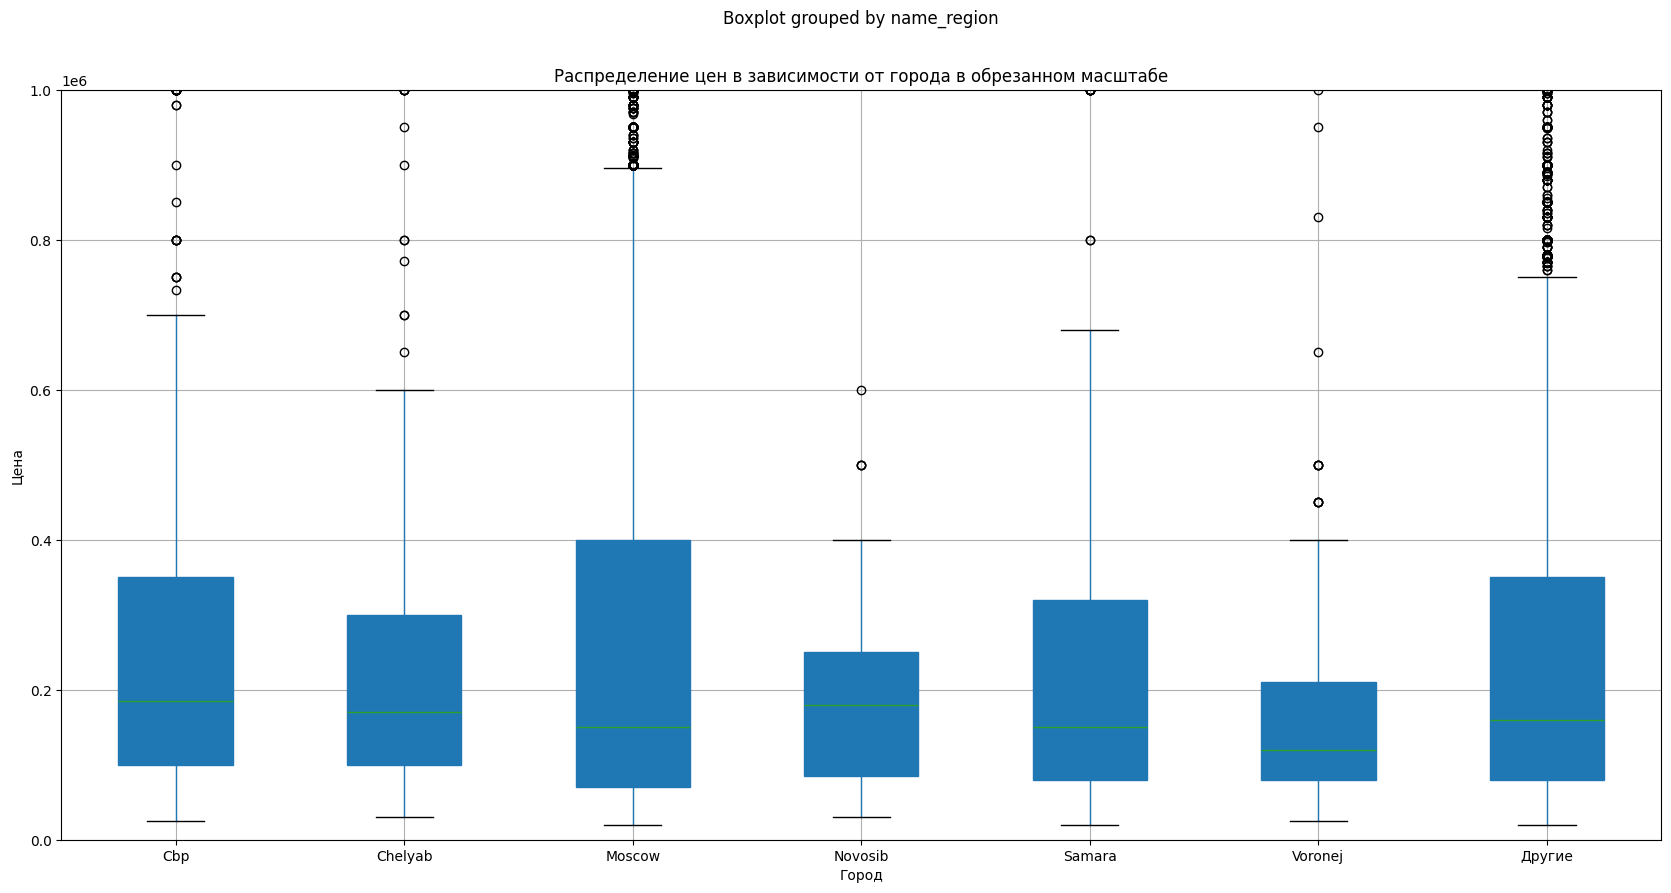

In [ ]:
ax = data.boxplot(column="price", by="name_region", figsize=(20, 10), patch_artist=True)
ax.set_ylim(0, 0.1 * 10**7)
ax.set_title("Распределение цен в зависимости от города в обрезанном масштабе")
ax.set_xlabel("Город")
ax.set_ylabel("Цена")


---



#ИМПОРТИРУЕМ БИБЛИОТЕКУ DATETIME, ЧТОБЫ РАБОТАТЬ СО ВРЕМЕНЕМ. ИДЕЯ: ОТБРОСИТЬ ВСЕ СТАРЫЕ ПОКУПКИ, ЭТО СВЯЗАНО С ИНФЛЯЦИЕЙ ЦЕН И ТЕМ ФАКТОМ, ЧТО НАС ИНТЕРЕСУЕТ ЦЕНА В ДАННЫЙ МОМЕНТ ВРЕМЕНИ

In [ ]:
current_data = datetime.now()

def data_transform(date_in_data):
    difference_in_time = str(current_data - datetime.strptime(date_in_data, "%Y-%m-%d %H:%M:%S")).split()[0]
    return int(difference_in_time)
data["date"] = data["date"].apply(data_transform)

In [ ]:
data = data.loc[data.groupby("plate")["date"].idxmin()]

In [ ]:
print(len(data["plate"]) - len(set(data["plate"])))

0


In [ ]:
data.isnull().sum()

,0
id,0
plate,0
date,0
price,0
region,0
name_region,0


#ПРОПУЩЕННЫХ ЗНАЧЕНИЙ НЕТ

In [ ]:
data.describe()

,id,date,price
count,43605.000000,43605.000000,4.360500e+04
mean,25813.128380,361.016627,4.384262e+05
std,14909.071927,325.847554,1.834132e+06
min,1.000000,45.000000,2.000000e+04
25%,12949.000000,86.000000,7.000000e+04
50%,25789.000000,242.000000,1.500000e+05
75%,38729.000000,567.000000,3.500000e+05
max,51635.000000,1500.000000,1.000000e+08


<ipython-input-327-db8040c463b7>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


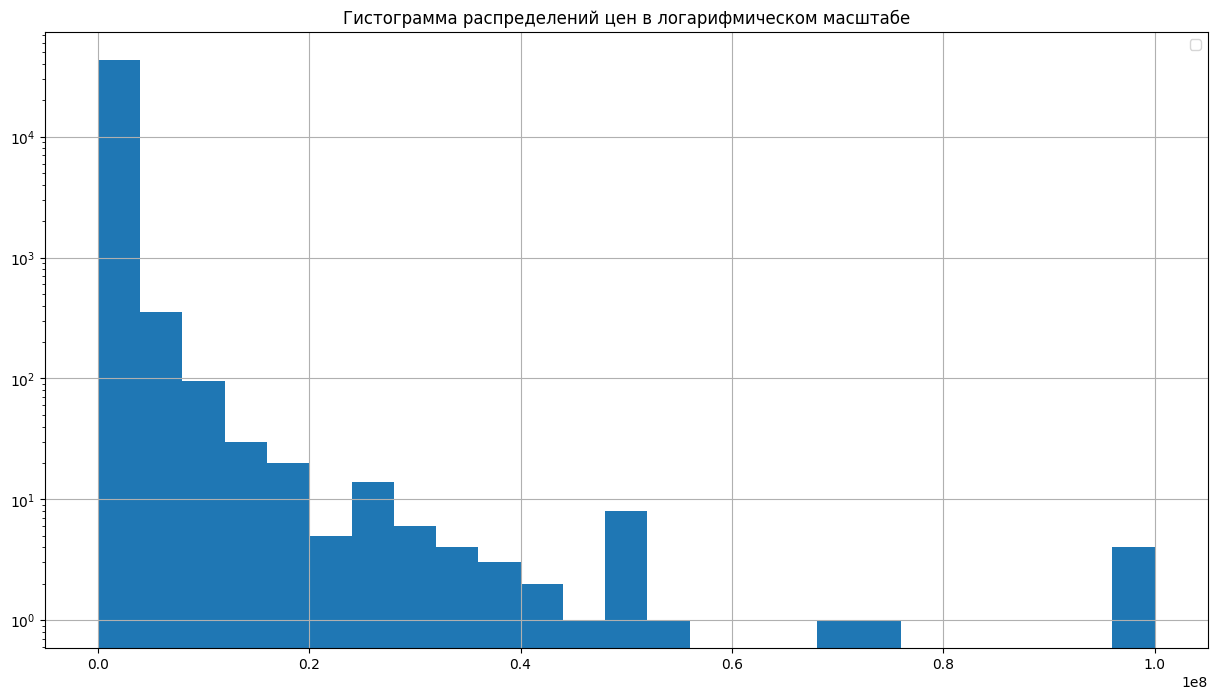

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(data["price"], bins=25, log=True)
plt.title("Гистограмма распределений цен в логарифмическом масштабе")
plt.legend()
plt.grid(True)


---
#ПОСМОТРИМ НА САМЫЕ НИЗКИЕ И НА САМЫЕ ВЫСОКИЕ ЦЕНЫ


In [ ]:
data[data["price"] == max(data["price"])]

,id,plate,date,price,region,name_region
43878,43879,B777CY77,239,100000000,077,Moscow
1794,1795,K252KK777,166,100000000,777,Moscow
21108,21109,M026MM08,364,100000000,008,Другие
47081,47082,X777XX05,278,100000000,005,Другие


In [ ]:
data[data["price"] == min(data["price"])]

,id,plate,date,price,region,name_region
27317,27318,A533MM702,518,20000,702,Другие
34078,34079,B904OX797,473,20000,797,Moscow
48328,48329,E307KE37,1047,20000,037,Другие
31797,31798,H202EB63,747,20000,063,Samara
16502,16503,K002BY197,812,20000,197,Moscow
41754,41755,K053YM777,1004,20000,777,Moscow
19292,19293,K963OK797,473,20000,797,Moscow
38220,38221,O494TP193,357,20000,193,Другие
37652,37653,O780BX799,473,20000,799,Moscow
47329,47330,P494MO777,1169,20000,777,Moscow


In [ ]:
data.shape

(43605, 6)



---
#ИДЕЯ В ТОМ , ЧТОБЫ КАЖДЫЙ НОМЕР РАЗОБРАТЬ НА КОЛИЧЕСТВО ПОВТОРЯЮЩИХСЯ ЭЛЕМЕНТОВ И НА ПРАВИТЕЛЬСТВЕННЫЕ НОМЕРА. ТАК ЖЕ УКАЖЕМ ВОЗМОЖНОСТЬ СВОБОДНОЙ ПОКУПКИ НОМЕРА И УРОВЕНЬ "ВОЗМОЖНОСТЕЙ" НОМЕРА НА ДОРОГЕ

In [ ]:
# ((letters, numbers range (from, to), region code)
#is it forbidden to buy (bool), do they have an advantage on the road (bool), level of significance (author's opinion))
GOVERNMENT_CODES = {
    # Moscow
    ("AMP", (0, 999), "97"): ("Government of Russia", 1, 1, 10),
    ("AMP", (0, 999), "77"): ("Partially Government of Russia", 0, 1, 8),
    ("EKX", (0, 999), "77"): ("Partially Federal Protective Service (Federal Protective Service)", 0, 1, 6),
    ("EKX", (0, 999), "97"): ("Partially Federal Protective Service (Federal Protective Service)", 0, 1, 6),
    ("EKX", (0, 999), "99"): ("Partially Federal Protective Service (Federal Protective Service)", 0, 1, 6),
    ("KKX", (0, 999), "77"): ("Partially used on vehicles of Ministry of Security/Federal Counterintelligence Service /Federal Security Service of Russia", 0, 0, 1),
    ("CAC", (500, 999), "77"): ("Former officially 'open' plates of Ministry of Security/Federal Counterintelligence Service /Federal Security Service of Russia", 0, 0, 1),
    ("CAC", (500, 999), "77"): ("Former officially 'open' plates of Ministry of Security/Federal Counterintelligence Service /Federal Security Service of Russia", 0, 0, 1),
    ("AOO", (0, 999), "77"): ("Partially Presidential Administrative Directorate plates", 0, 1, 6),
    ("BOO", (0, 999), "77"): ("Partially Presidential Administrative Directorate plates", 0, 1, 6),
    ("MOO", (0, 999), "77"): ("Partially Presidential Administrative Directorate plates", 0, 1, 6),
    ("COO", (0, 999), "77"): ("Partially Administrative Directorate, Federation Council plates", 0, 1, 6),
    ("AMM", (0, 999), "99"): ("Partially plates of Moscow City Duma deputies, police", 0, 1, 4),
    ("CCC", (0, 999), "77"): ("Partially Central Special Communication, Courier Service, Ministry of Communications", 0, 1, 3),
    ("CCC", (0, 999), "99"): ("Partially Tax Police, Customs, Special Communications", 0, 1, 3),
    ("CCC", (0, 999), "97"): ("Partially Central Special Communication, Courier Service, Ministry of Communications", 0, 1, 3),
    ("KKK", (0, 999), "99"): ("Initially belonged to Courier Service, now used among private individuals", 0, 0, 1),
    ("OOO", (0, 999), "77"): ("Initially intended for Federal Security Service", 0, 0, 1),
    ("KMM", (0, 999), "77"): ("Partially Fire Department plates", 0, 1, 3),
    ("MMP", (300, 320), "77"): ("Partially Federal Security Service plates", 0, 1, 4),
    ("MMP", (0, 299), "77"): ("Partially Government of Russia, Federal Security Service, banks, and private individuals with connections in the traffic police", 0, 1, 2),
    ("MMP", (321, 999), "77"): ("Partially Government of Russia, Federal Security Service, banks, and private individuals with connections in the traffic police", 0, 1, 2),
    ("PMP", (0, 999), "77"): ("Partially Ministry of Justice plates", 0, 1, 3),
    ("AMO", (0, 999), "77"): ("Partially Moscow City Hall plates", 0, 1, 5),
    ("KOO", (0, 999), "77"): ("Partially Constitutional Court plates", 0, 1, 3),
    ("EPE", (0, 999), "77"): ("Partially State Duma plates", 0, 1, 3),
    ("AAA", (0, 999), "77"): ("Partially Administration of the President plates", 0, 1, 6),
    ("KMP", (0, 999), "77"): ("Partially Government of Russia plates", 0, 1, 3),
    ("TMP", (0, 999), "77"): ("Partially Government of Russia plates, as well as private individuals with connections in the traffic police", 0, 1, 2),
    ("YMP", (0, 999), "77"): ("Partially Government of Russia plates, as well as private individuals with connections in the traffic police", 0, 1, 2),
    ("XXX", (0, 999), "77"): ("Private individuals with connections in the traffic police", 0, 1, 2),
    ("YYY", (0, 999), "77"): ("Private individuals with connections in the traffic police", 0, 1, 2),
    ("XKX", (0, 999), "77"): ("Partially Federal Security Service and Federal Protective Service plates", 0, 1, 2),
    ("OMP", (0, 999), "77"): ("Partially Government of Russia, banks, and private individuals with connections in the traffic police", 0, 1, 2),
    ("EEE", (0, 999), "77"): ("Private individuals with connections in the traffic police", 0, 1, 2),

    # Moscow Oblast
    ("AMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("BMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("KMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("CMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("OMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("MMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("TMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("HMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("YMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("XMO", (0, 999), "50"): ("Partially various government agencies (administration, ambulance, traffic police, etc.)", 0, 1, 3),
    ("AMM", (0, 999), "50"): ("Partially plates of the regional administration", 0, 1, 5),
    ("AMM", (0, 999), "90"): ("Partially plates of the regional administration", 0, 1, 5),
    ("MMM", (0, 999), "50"): ("Partially plates of law enforcement in the region (prosecutor's office, EMERCOM, traffic police, etc.)", 0, 1, 5),
    ("MMM", (0, 999), "90"): ("Partially plates of law enforcement in the region (prosecutor's office, EMERCOM, traffic police, etc.)", 0, 1, 5),

    # Saint Petersburg
    ("OBO", (0, 999), "78"): ("Partially Departmental Security Service plates", 0, 1, 4),
    ("OBO", (0, 999), "98"): ("Partially Departmental Security Service plates", 0, 1, 4),
    ("OTT", (0, 999), "78"): ("Partially former traffic police plates (now replaced by 98)", 0, 0, 1),
    ("OTT", (0, 999), "98"): ("Partially traffic police plates", 0, 1, 4),
    ("OMM", (0, 999), "78"): ("Partially city district police plates", 0, 1, 3),
    ("OMM", (0, 999), "98"): ("Partially city district police plates", 0, 1, 3),
    ("OOM", (0, 999), "78"): ("Partially plates of the Main Department of Internal Affairs", 0, 1, 3),
    ("OOM", (0, 999), "98"): ("Partially plates of the Main Department of Internal Affairs", 0, 1, 3),
    ("OKO", (0, 100), "78"): ("Partially former plates of the prosecutor's office and judicial department (now replaced by 98)", 0, 0, 1),
    ("OKO", (0, 100), "98"): ("Partially plates of the prosecutor's office and judicial department", 0, 1, 3),
    ("OKO", (700, 999), "78"): ("Partially former Federal Security Service plates (now replaced by 98)", 0, 0, 1),
    ("OKO", (700, 999), "98"): ("Partially Federal Security Service plates", 0, 1, 3),
    ("OPP", (0, 999), "78"): ("Partially former plates of the Main Department of Internal Affairs (now replaced by 98)", 0, 0, 1),
    ("OPP", (0, 999), "98"): ("Partially plates of the Main Department of Internal Affairs", 0, 1, 3),
    ("OOH", (0, 999), "78"): ("Partially Federal Drug Control Service and Federal Tax Service plates", 0, 1, 3),
    ("OOH", (0, 999), "98"): ("Partially Federal Drug Control Service and Federal Tax Service plates", 0, 1, 3),
    ("OAO", (0, 999), "78"): ("Partially plates of the city and regional administration", 0, 1, 5),
    ("OAO", (0, 999), "98"): ("Partially plates of the city and regional administration", 0, 1, 5),
    ("AAA", (0, 100), "78"): ("Partially plates of the city and regional administration", 0, 1, 6),
    ("AAA", (0, 100), "98"): ("Partially plates of the city and regional administration", 0, 1, 6),
    ("OOO", (0, 899), "78"): ("Commercial plates", 0, 0, 2),
    ("OOO", (0, 899), "98"): ("Commercial plates", 0, 0, 2),
    ("OOO", (900, 999), "78"): ("Partially Federal Protective Service plates", 0, 1, 3),
    ("OOO", (900, 999), "98"): ("Partially Federal Protective Service plates", 0, 1, 3),
    ("OKC", (0, 999), "98"): ("Partially Constitutional Court of the Russian Federation plates", 0, 1, 3),
    ("OOC", (0, 999), "78"): ("Partially plates of heads of enterprises and organizations", 0, 0, 2),
    ("OOC", (0, 999), "98"): ("Partially plates of heads of enterprises and organizations", 0, 0, 2),
    ("MMM", (0, 999), "78"): ("Commercial plates", 0, 0, 2),
    ("MMM", (0, 999), "98"): ("Commercial plates", 0, 0, 2),

    # Altai Republic
    ("XXX", (0, 999), "04"): ("Widespread 'special' plates", 0, 0, 2),
    ("TTT", (0, 999), "04"): ("Rare 'special' plates", 0, 0, 2),
    ("PPP", (0, 999), "04"): ("Partially prosecutor's office of the republic", 0, 1, 3),
    ("PPA", (0, 999), "04"): ("Partially prosecutor's office of the republic", 0, 1, 3),
    ("MPA", (0, 999), "04"): ("Partially Ministry of Internal Affairs of the republic", 0, 1, 3),
    ("OOO", (0, 999), "04"): ("Partially plates of the government of the republic", 0, 1, 5),
    ("HHH", (0, 999), "04"): ("Partially the republic's tax service plates", 0, 1, 3),
    ("CCC", (0, 999), "04"): ("Partially plates belonging to the republic's judges", 0, 1, 3),

    # Republic of Bashkortostan
    ("PKC", (0, 999), "02"): ("Partially State Assembly (Kurultai) plates", 0, 1, 5),
    ("KKC", (0, 999), "02"): ("Partially State Assembly (Kurultai) plates", 0, 1, 5),
    ("OOO", (0, 999), "02"): ("Partially plates of leaders of large enterprises and ministries", 0, 1, 3),
    ("AAA", (0, 999), "02"): ("Partially plates of the republic's government", 0, 1, 5),

    # Republic of Karelia
    ("TTT", (0, 999), "10"): ("Partially government of the republic and Federal Security Service plates", 0, 1, 5),
    ("HHH", (0, 999), "10"): ("Partially plates of city and district administrations of the republic", 0, 1, 4),
    ("MMM", (0, 999), "10"): ("Partially plates of the Ministry of Internal Affairs of the republic", 0, 1, 3),
    ("EMP", (0, 999), "10"): ("Partially plates of the Ministry of Internal Affairs of the republic", 0, 1, 3),
    ("CCC", (0, 999), "10"): ("Partially plates of the prosecutor's office and judges' vehicles", 0, 1, 3),

    # Komi Republic
    ("TTT", (0, 999), "11"): ("Partially government of the republic and Federal Security Service plates", 0, 1, 5),
    ("OOO", (0, 999), "11"): ("Widespread semi-special plates, leaders of large industrial companies", 0, 1, 3),

    # Sakha Republic
    ("PPP", (0, 999), "14"): ("Partially plates of the republic's prosecutor's office", 0, 1, 3),
    ("AAA", (0, 999), "14"): ("Motor pool of the President, Government, Parliament of the republic, as well as heads of state enterprises", 0, 1, 5),

    # Republic of Tatarstan
    ("OAA", (0, 999), "16"): ("Partially plates of heads of district administrations", 0, 1, 5),
    ("OAA", (0, 999), "116"): ("Partially plates of heads of district administrations", 0, 1, 5),
    ("OAA", (0, 999), "716"): ("Partially plates of heads of district administrations", 0, 1, 5),

    # Krasnodar Krai
    ("PPP", (0, 999), "23"): ("Partially plates of the Krai and city administrations", 0, 1, 5),
    ("HHH", (0, 999), "23"): ("Partially plates of the tax authorities", 0, 1, 3),
    ("OOO", (0, 999), "23"): ("Partially plates of the Krai and city administrations", 0, 1, 5),
    ("KKK", (0, 999), "23"): ("Partially plates of the Krai administration", 0, 1, 5),

    # Krasnoyarsk Krai
    ("KPK", (0, 999), "24"): ("Partially plates of the Krai administration", 0, 1, 5),
    ("OOO", (0, 999), "24"): ("Partially Federal Security Service plates of the Krai", 0, 1, 3),
    ("MKK", (0, 999), "24"): ("Partially former plates of the Ministry of Internal Affairs of the Krai", 0, 0, 1),

    # Primorsky Krai
    ("BOO", (0, 999), "25"): ("Partially military plates", 0, 1, 3),
    ("BOO", (0, 999), "125"): ("Partially city services plates in Vladivostok and districts", 0, 1, 2),
    ("AAA", (0, 999), "25"): ("Issued first in Vladivostok", 0, 0, 2),
    ("AAA", (0, 999), "125"): ("One of the most 'special' series, prosecutor's office", 1, 1, 5),
    ("HHH", (0, 999), "25"): ("Partially plates of the administration and vehicles of City Duma deputies", 0, 1, 3),
    ("MMM", (0, 999), "25"): ("Partially plates of the deputies of the Krai Legislative Assembly", 0, 1, 3),
    ("CCC", (0, 999), "25"): ("Partially plates of the Krai administration", 0, 1, 5),
    ("XXX", (0, 999), "25"): ("Partially plates of the prosecutor's office and the Department of Internal Affairs", 0, 1, 2),
    ("OOO", (0, 999), "25"): ("Partially former plates of the Krai administration (during Governor Evgeny Nazdratenko)", 0, 0, 1),
    ("TTT", (0, 999), "25"): ("Partially former plates of the Vladivostok administration and federal agencies in the Krai (during Mayor Yuri Kopylov)", 0, 0, 1),
    ("MBK", (0, 999), "25"): ("Partially plates for employees of the Department of Internal Affairs", 0, 1, 3),
    ("MBK", (0, 999), "125"): ("Partially plates for employees of the Department of Internal Affairs", 0, 1, 3),
    ("MOO", (0, 999), "25"): ("Partially plates for Krai agencies of the Department of Internal Affairs, EMERCOM, firefighters, etc.", 0, 1, 2),
    ("MOO", (0, 999), "125"): ("Partially plates for Krai agencies of the Department of Internal Affairs, EMERCOM, firefighters, etc.", 0, 1, 2),
    ("HOO", (0, 999), "25"): ("Partially plates of the Department of Internal Affairs, traffic police in the southeastern region of the Krai (Nakhodka)", 0, 1, 3),
    ("HOO", (0, 999), "125"): ("Partially plates of the Department of Internal Affairs, traffic police in the southeastern region of the Krai (Nakhodka)", 0, 1, 3),
    ("YOO", (0, 999), "25"): ("Partially plates of the Department of Internal Affairs, traffic police in the central region of the Krai (Ussuriysk)", 0, 1, 3),
    ("YOO", (0, 999), "125"): ("Partially plates of the Department of Internal Affairs, traffic police in the central region of the Krai (Ussuriysk)", 0, 1, 3),
    ("COO", (0, 999), "25"): ("Partially plates of the Department of Internal Affairs, traffic police in the northern region of the Krai (Spassk-Dalny)", 0, 1, 3),
    ("COO", (0, 999), "125"): ("Partially plates of the Department of Internal Affairs, traffic police in the northern region of the Krai (Spassk-Dalny)", 0, 1, 3),

    # Vologda Oblast
    ("AAA", (0, 999), "35"): ("Partially plates of the regional government and Vologda city administration", 0, 1, 5),

    # Volgograd Oblast
    ("AAM", (0, 999), "34"): ("Partially plates of the Oblast Duma", 0, 1, 3),
    ("PAA", (0, 999), "34"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("AAA", (0, 999), "34"): ("Partially plates of the Oblast Prosecutor's Office", 0, 1, 3),
    ("ACK", (0, 999), "34"): ("Partially plates of the Investigative Committee, Main Department of Internal Affairs", 0, 1, 3),
    ("YYY", (0, 999), "34"): ("Partially Federal Security Service plates", 0, 1, 3),
    ("AAK", (0, 999), "34"): ("Partially plates of the Federal Bailiff Service, Ministry of Justice, and Judicial Department", 0, 1, 3),

    # Voronezh Oblast
    ("ААА", (0, 999), "36"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("BOA", (0, 999), "36"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("MMM", (0, 999), "36"): ("Partially plates of the Oblast Prosecutor's Office", 0, 1, 3),

    # Kaliningrad Oblast
    ("AAK", (0, 999), "39"): ("Partially plates of the Oblast Administration, Federal Security Service, and Prosecutor's Office", 0, 1, 5),
    ("KKK", (0, 999), "39"): ("Partially plates of the Oblast Administration, Federal Security Service, and Prosecutor's Office", 0, 1, 5),
    ("PPP", (0, 999), "39"): ("Partially former plates of the Oblast Administration (during Governor Boos)", 0, 0, 1),

    # Kaluga Oblast
    ("OOO", (0, 999), "40"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("TTT", (0, 999), "40"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("PPP", (0, 999), "40"): ("Partially plates of the Oblast Prosecutor's Office", 0, 1, 3),

    # Kurgan Oblast
    ("OOO", (0, 999), "45"): ("Partially former plates of the Oblast Administration", 0, 0, 1),
    ("TTT", (0, 999), "45"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("OKO", (0, 999), "45"): ("Partially plates of the Oblast Prosecutor's Office", 0, 1, 3),

    # Novosibirsk Oblast
    ("AAA", (0, 199), "54"): ("Plates for Presidential Plenipotentiaries", 1, 1, 7),
    ("AAA", (200, 999), "54"): ("'Special' plates", 0, 1, 4),
    ("HHH", (0, 999), "54"): ("Partially plates of the Novosibirsk mayor's office, Oblast Administration, and Oblast Council", 0, 1, 5),
    ("ACK", (0, 999), "54"): ("Partially Federal Security Service plates of the Oblast", 0, 1, 3),
    ("AHO", (0, 999), "54"): ("Partially former plates of the Oblast Administration", 0, 0, 1),
    ("AAO", (0, 999), "54"): ("Partially plates of various government agencies, including district administrations of Novosibirsk", 0, 1, 3),
    ("PPP", (0, 999), "54"): ("'Morozov' plates (introduced by former head of traffic police Pyotr Morozov)", 0, 1, 2),
    ("MOP", (0, 999), "54"): ("'Morozov' plates (introduced by former head of traffic police Pyotr Morozov)", 0, 1, 2),

    # Oryol Oblast
    ("AAA", (0, 999), "57"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("AOO", (0, 999), "57"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("OAO", (0, 999), "57"): ("Partially plates of directors of public joint-stock companies", 0, 1, 2),

    # Rostov Oblast
    ("APO", (0, 999), "61"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("AAA", (0, 999), "61"): ("Partially plates of district heads of Rostov-on-Don, mayors of Oblast cities", 0, 1, 5),
    ("APY", (0, 999), "61"): ("Partially plates of the Rostov-on-Don administration", 0, 1, 5),
    ("KKK", (0, 999), "61"): ("Partially former plates for Presidential Plenipotentiaries (during Viktor Kazantsev)", 0, 0, 1),
    ("HHH", (0, 999), "61"): ("Partially plates of the Oblast Prosecutor's Office", 0, 1, 3),
    ("MMM", (0, 999), "61"): ("Partially plates of the Oblast Department of Internal Affairs", 0, 1, 3),
    ("OOO", (0, 999), "61"): ("Partially plates of the Oblast Legislative Assembly", 0, 1, 4),
    ("BBK", (0, 999), "61"): ("Partially plates of insurance companies in Rostov-on-Don", 0, 1, 1),

    # Saratov Oblast
    ("AAA", (0, 999), "164"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("PPP", (0, 999), "164"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("XXX", (0, 999), "64"): ("Partially plates of the Oblast courts", 0, 1, 3),
    ("MMM", (0, 999), "64"): ("Partially plates of the Oblast Prosecutor's Office", 0, 1, 3),
    ("OAA", (0, 999), "64"): ("Partially Federal Security Service plates of the Oblast", 0, 1, 3),

    # Tomsk Oblast
    ("ATO", (0, 999), "70"): ("Partially plates of the Oblast Administration", 0, 1, 5),

    # Tyumen Oblast
    ("ATO", (0, 999), "72"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("PTO", (0, 999), "72"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("MTO", (0, 999), "72"): ("Partially plates of the Oblast Prosecutor's Office", 0, 1, 3),
    ("HTO", (0, 999), "72"): ("Partially plates of the Tax Service", 0, 1, 3),
    ("CTO", (0, 999), "72"): ("Partially plates of the Oblast courts", 0, 1, 3),
    ("YTO", (0, 999), "72"): ("Partially plates of the bailiff service", 0, 1, 3),
    ("BAA", (0, 999), "72"): ("Partially plates of the Oblast Ministry of Internal Affairs", 0, 1, 3),
    ("KKK", (0, 999), "72"): ("'Gangster' plates", 0, 1, 1),

    # Arkhangelsk Oblast
    ("TTT", (0, 999), "29"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("PPP", (0, 999), "29"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("MAO", (0, 999), "29"): ("Partially plates of the Oblast Ministry of Internal Affairs", 0, 1, 3),

    # Ryazan Oblast
    ("APO", (0, 999), "62"): ("Partially plates of the Oblast Administration", 0, 1, 5),

    # Samara Oblast
    ("PAA", (0, 999), "63"): ("Partially plates of the Oblast Administration", 0, 1, 5),
    ("AAP", (0, 999), "63"): ("Partially plates of the Oblast Administration", 0, 1, 5),
}


#РАЗРАБОТАЕМ АНАЛОГ ONE-HOT-ENCODER'а

In [ ]:
data["Triplet_letters"] = 0
data["Double_letters"] = 0
data["Single_letters"] = 0
data["Sixtet_numbers"] = 0
data["Kvintet_numbers"] = 0
data["Quartet_number"] = 0
data["Triplet_numbers"] = 0
data["Doublet_numbers"] = 0
data["Singlet_numbers"] = 0
data["AbilityToBuy"] = 0
data["AdventagesOnRoad"] = 0
data["LevelSign"] = 0

for index, plate_in in data[["id", "plate"]].iterrows():
    plate = plate_in["plate"]
    letter_part = plate[0] + plate[4:6]
    number_part = plate[1:4]
    reg_part = plate[6:]

    for key in GOVERNMENT_CODES.keys():
      gov_let, gov_num, gov_reg = key

      if (letter_part == gov_let) and (gov_num[0] <= int(number_part) <= gov_num[1]) and reg_part == gov_reg:
          data.loc[index, "AbilityToBuy"] = GOVERNMENT_CODES[key][1]
          data.loc[index, "AdventagesOnRoad"] = GOVERNMENT_CODES[key][2]
          data.loc[index, "LevelSign"] = GOVERNMENT_CODES[key][3]

    letter_count = {}
    number_count = {}

    for char in plate_in['plate']:
        if char.isdigit():
            number_count[char] = number_count.get(char, 0) + 1
        else:
            letter_count[char] = letter_count.get(char, 0) + 1

    for let, seq in letter_count.items():
        if seq == 3:
            data.loc[index, "Triplet_letters"] += 1
        elif seq == 2:
            data.loc[index, "Double_letters"] += 1
        elif seq == 1:
            data.loc[index, "Single_letters"] += 1

    for num, seq in number_count.items():
        if seq == 6:
            data.loc[index, "Sixtet_numbers"] += 1
        elif seq == 5:
            data.loc[index, "Kvintet_numbers"] += 1
        elif seq == 4:
            data.loc[index, "Quartet_number"] += 1
        elif seq == 3:
            data.loc[index, "Triplet_numbers"] += 1
        elif seq == 2:
            data.loc[index, "Doublet_numbers"] += 1
        elif seq == 1:
            data.loc[index, "Singlet_numbers"] += 1

    data.shape
    letter_count.clear()
    number_count.clear()

In [ ]:
data['LevelSign'].value_counts()

,count
LevelSign,
0,43063
3,150
2,129
5,111
6,49
1,42
4,40
8,21


In [ ]:
data.sample(5)

,id,plate,date,price,region,name_region,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers,AbilityToBuy,AdventagesOnRoad,LevelSign
19602,19603,A555OK197,114,900000,197,Moscow,0,0,3,0,0,0,1,0,3,0,0,0
49615,49616,P414HA123,314,80000,123,Другие,0,0,3,0,0,0,0,2,2,0,0,0
39194,39195,X777BH50,493,550000,050,Другие,0,0,3,0,0,0,1,0,2,0,0,0
5528,5529,E199XK197,703,300000,197,Moscow,0,0,3,0,0,0,1,1,1,0,0,0
45273,45274,Y111HO777,558,2750000,777,Moscow,0,0,3,0,0,0,2,0,0,0,0,0


#ПОСМОТРИМ НА МАТРИЦУ КОРРЕЛЯЦИЙ

In [ ]:
data = data.drop(["id", "plate", "date", "region", "name_region"], axis=1)

<Axes: >

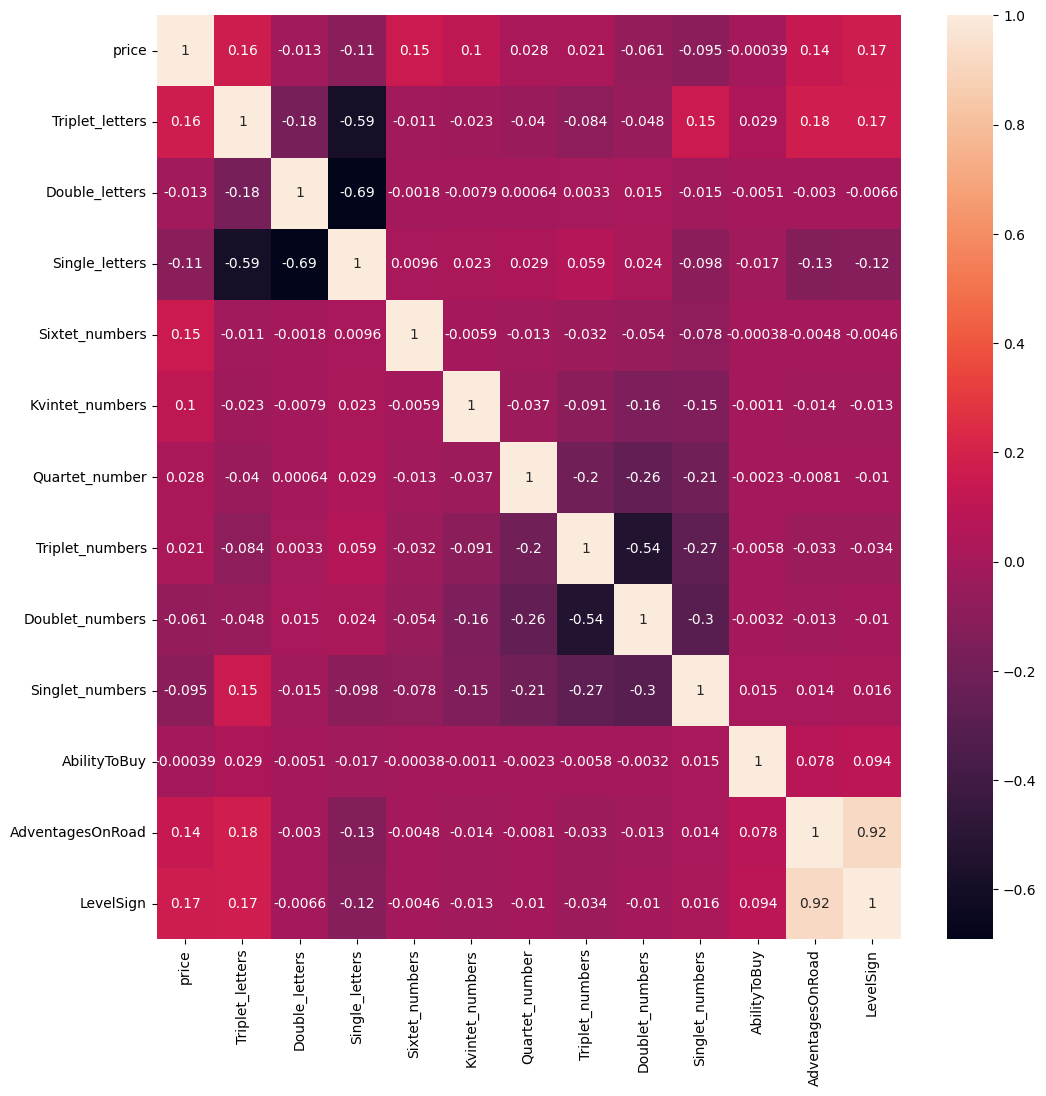

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=data.corr(), annot=True)

<Axes: >

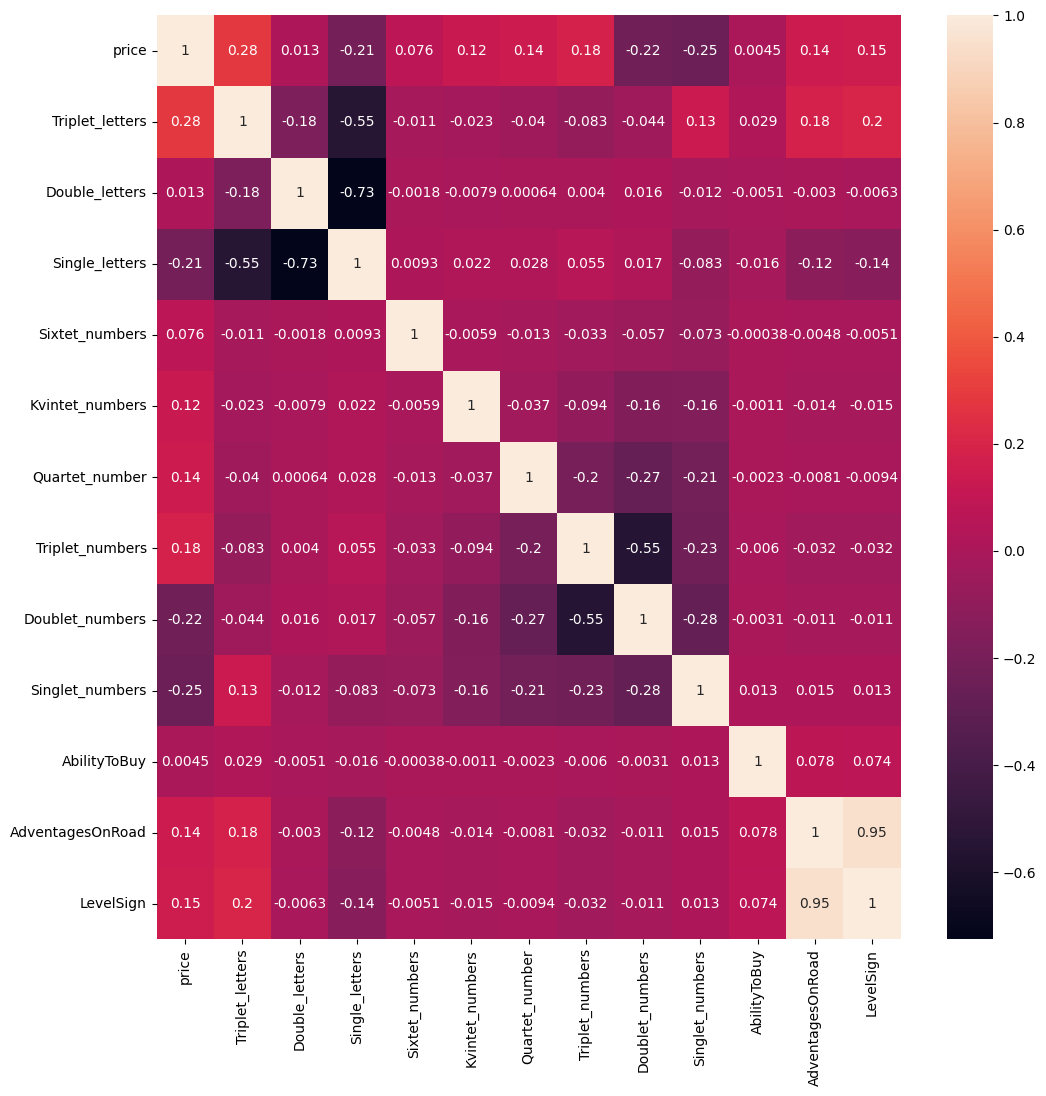

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=data.corr(method="spearman"), annot=True)



---
#ПЕРЕЙДЁМ К ПОДБОРУ МОДЕЛИ И ГИПЕРПАРАМЕТРОВ. РАЗОБЬЁМ ДАННЫЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ , ЧТОБЫ ОЦЕНИТЬ РАБОТОСПОСОБНОСТЬ МОДЕЛИ


In [ ]:
data, y = data.drop(["price"], axis=1), data["price"]

In [ ]:
data.sample(4)

,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers,AbilityToBuy,AdventagesOnRoad,LevelSign
31919,0,0,3,0,0,1,0,0,2,0,0,0
11257,0,0,3,0,0,0,1,0,3,0,0,0
37391,0,0,3,0,0,0,0,3,0,0,0,0
13071,0,1,1,0,0,0,0,2,1,0,0,0


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(data, y, test_size = 0.2, shuffle=True)
dtree = DecisionTreeRegressor()

param_grid3 = {
    "criterion":["squared_error", "absolute_error"],
    "max_depth":[10, 12, 14],
    "min_samples_split":[12, 15, 17],
    "min_samples_leaf":[1, 2],
}
grid_search3 = GridSearchCV(dtree, param_grid3, cv=3)
grid_search3.fit(xtrain, ytrain)
print("Best parametrs of Decision Tree", grid_search3.best_params_)
best_Dtree = grid_search3.best_estimator_
#dtree.fit(data, y)
print(mean_absolute_percentage_error(ytest, best_Dtree.predict(xtest)))

Best parametrs of Decision Tree {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 12}
1.8538103585305443


In [ ]:
RFS = RandomForestRegressor()
param_grid2 = {
    "n_estimators": [2, 4, 10, 12],
    "max_depth": [20, 25, 30, 35],
    "min_samples_split":[15, 17, 20],
    "min_samples_leaf":[1, 2, 3]
}
grid_search2 = GridSearchCV(estimator=RFS, param_grid=param_grid2, cv=5)
grid_search2.fit(xtrain, ytrain)
print("Best parametrs of RFS ", grid_search2.best_params_)
best_rf = grid_search2.best_estimator_
print(mean_absolute_percentage_error(ytest, best_rf.predict(xtest)))

Best parametrs of RFS  {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 17, 'n_estimators': 4}
1.8556135069677353


In [ ]:
ModelXGB = xgb.XGBRegressor()

param_grid = {
    "n_estimators": [250, 300],
    "max_depth": [7, 10, 15],
    "learning_rate": [0.01, 0.013],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.33, 0.66, 1.0]
}
grid_search = GridSearchCV(estimator=ModelXGB, param_grid=param_grid, cv=5)
grid_search.fit(xtrain, ytrain)
best_model = grid_search.best_estimator_
print("The best parametrs: ", grid_search.best_params_)
print("MAPE: ",mean_absolute_percentage_error(ytest, best_model.predict(xtest)))

The best parametrs:  {'colsample_bytree': 0.66, 'learning_rate': 0.013, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.6}
MAPE:  1.955444097518921


P.S. На деле я пробовал кууудаа больше гиперпараметров

---



#ДАЛЕЕ ПОДГРУЖАЕМ ТЕСТОВЫЕ ДАННЫЕ , ДЛЯ УЧАСТИЯ В СОРЕВНОВАНИИ НА KAGGLE

In [ ]:
test_data = pd.read_csv("test.csv")
tt = test_data.copy()


test_data["Triplet_letters"] = 0
test_data["Double_letters"] = 0
test_data["Single_letters"] = 0
test_data["Sixtet_numbers"] = 0
test_data["Kvintet_numbers"] = 0
test_data["Quartet_number"] = 0
test_data["Triplet_numbers"] = 0
test_data["Doublet_numbers"] = 0
test_data["Singlet_numbers"] = 0
test_data["AbilityToBuy"] = 0
test_data["AdventagesOnRoad"] = 0
test_data["LevelSign"] = 0

for index, plate_in in enumerate(test_data["plate"]):
    letter_part = plate[0] + plate[4:6]
    number_part = plate[1:4]
    reg = plate[6:]

    for key in GOVERNMENT_CODES.keys():
      gov_let, gov_num, gov_reg = key

      if (letter_part == gov_let) and (gov_num[0] <= int(number_part) <= gov_num[1]) and reg == gov_reg:
          data.loc[index, "AbilityToBuy"] = GOVERNMENT_CODES[key][1]
          data.loc[index, "AdventagesOnRoad"] = GOVERNMENT_CODES[key][2]
          data.loc[index, "LevelSign"] = GOVERNMENT_CODES[key][3]

    letter_count = {}
    number_count = {}

    for char in plate_in:
        if char.isdigit():
            number_count[char] = number_count.get(char, 0) + 1
        else:
            letter_count[char] = letter_count.get(char, 0) + 1

    for let, seq in letter_count.items():

        if seq == 3:
            test_data.at[index, "Triplet_letters"] += 1
        elif seq == 2:
            test_data.at[index, "Double_letters"] += 1
        elif seq == 1:
            test_data.at[index, "Single_letters"] += 1

    for num, seq in number_count.items():

        if seq == 6:
            test_data.at[index, "Sixtet_numbers"] += 1
        elif seq == 5:
            test_data.at[index, "Kvintet_numbers"] += 1
        elif seq == 4:
            test_data.at[index, "Quartet_number"] += 1
        elif seq == 3:
            test_data.at[index, "Triplet_numbers"] += 1
        elif seq == 2:
            test_data.at[index, "Doublet_numbers"] += 1
        elif seq == 1:
            test_data.at[index, "Singlet_numbers"] += 1

    test_data.shape
    letter_count.clear()
    number_count.clear()

test_data = test_data.drop(["id", "plate", "date", "price"], axis=1)

In [ ]:
test_data.head(3)

,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers,AbilityToBuy,AdventagesOnRoad,LevelSign
0,0,1,1,0,0,0,1,1,1,0,0,0
1,0,0,3,0,0,0,0,1,4,0,0,0
2,0,0,3,0,0,0,2,0,0,0,0,0


In [ ]:
rfs = RandomForestRegressor(max_depth=35, min_samples_leaf=2, min_samples_split=17, n_estimators=4)
rfs.fit(data, y)

RandomForestRegressor(max_depth=35, min_samples_leaf=2, min_samples_split=17,
                      n_estimators=4)

In [ ]:
tt["price"] = rfs.predict(test_data)

In [ ]:
tt.head(4)

,id,plate,date,price
0,51636,P700TT790,2025-01-27 00:00:00,332170.483189
1,51637,M081TX797,2025-02-10 00:00:00,124285.760513
2,51638,T333HX777,2025-02-11 00:00:00,602506.841417
3,51639,H744BH977,2025-02-03 00:00:00,332170.483189


In [ ]:
tt = tt.drop(["plate", "date"], axis=1)
tt.to_csv("Result.csv", index=False)